<a href="https://colab.research.google.com/github/apof/Information-Retrieval---Data-Mining-/blob/main/IRDM_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt

%matplotlib inline

**Load The Data and Process the with Pandas DataFrames**

In [3]:
train_data_file = "drive/MyDrive/Datasets/IRDM/train_data.tsv"
test_data_file = "drive/MyDrive/Datasets/IRDM/validation_data.tsv"

In [4]:
col_names=['qid','pid','query','passage','relevancy']

train_data_init=pd.read_csv(train_data_file, sep='\t', header=None, names=col_names)
train_data_df=pd.DataFrame(train_data_init)
train_data_df = train_data_df.iloc[1:]

test_data_init=pd.read_csv(test_data_file, sep='\t', header=None, names=col_names)
test_data_df=pd.DataFrame(test_data_init)
test_data_df = test_data_df.iloc[1:]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train_data_df["relevancy"] = train_data_df.relevancy.astype(float)
test_data_df["relevancy"] = test_data_df.relevancy.astype(float)

In [6]:
train_labels = train_data_df['relevancy'].values
test_labels = test_data_df['relevancy'].values

In [7]:
train_passages = train_data_df['passage'].values
train_queries = train_data_df['query'].values
train_pids = train_data_df['pid'].values
train_qids = train_data_df['qid'].values

In [8]:
test_passages = test_data_df['passage'].values
test_queries = test_data_df['query'].values
test_pids = test_data_df['pid'].values
test_qids = test_data_df['qid'].values

**Create Dictionaries for the Training and Testing Data**

In [9]:
train_passage_dict = {}
train_query_dict = {}
for i, _ in enumerate(train_queries):
  train_passage_dict[train_pids[i]] = train_passages[i]
  train_query_dict[train_qids[i]] = train_queries[i]

In [10]:
test_passage_dict = {}
test_query_dict = {}
for i, _ in enumerate(test_queries):
  test_passage_dict[test_pids[i]] = test_passages[i]
  test_query_dict[test_qids[i]] = test_queries[i]

**Correct Imbalanced Data with Negative Sampling**

In [11]:
def collect_relevant_pids(pids,qids,relevancy):

  relevancy_dict = {}
  ## collect for each query all the relevant passages (relevant passages is the minority class)
  ## and then sample randomply K negative examples

  for i, qid in enumerate(qids):
    if(relevancy_dict.get(qid) == None):
      if(relevancy[i] == 0):
        relevancy_dict[qid] = [[],[(pids[i],i)]]
      else:
        relevancy_dict[qid] = [[(pids[i],i)],[]]
    else:
      l = relevancy_dict.get(qid)
      if(relevancy[i] == 0):
        l[1].append((pids[i],i))
      else:
        l[0].append((pids[i],i))
      relevancy_dict[qid] = l

  return relevancy_dict

In [12]:
train_relevant_passages_dict = collect_relevant_pids(train_pids,train_qids,train_labels)

In [13]:
test_relevant_passages_dict = collect_relevant_pids(test_pids,test_qids,test_labels)

In [14]:
def negative_sampling(relevant_passages_dict,passage_dict,query_dict,K):

  sampled_passages = []
  sampled_queries = []
  sampled_labels = []
  sampled_qids = []
  sampled_pids = []


  for key in relevant_passages_dict:
    l = relevant_passages_dict.get(key)

    number_of_positive_samples = len(l[0])
    number_of_negative_passages = len(l[1])

    #print("query " + str(key) + " has " + str(number_of_positive_samples) + " positive and " + str(number_of_negative_passages) + " negative sample" )

    ## if there are not relevant passages continue
    if(number_of_positive_samples != 0):
      ## collect all relevant passages
      for (pid,_) in l[0]:
        sampled_queries.append(query_dict.get(key))
        sampled_passages.append(passage_dict.get(pid))
        sampled_labels.append(1)
        sampled_qids.append(key)
        sampled_pids.append(pid)

      negative_examples_to_draw = None
      ## if the positive examples for a query are more than the negative one --> select all the negative and add them to the dataset
      if(number_of_positive_samples >= number_of_negative_passages):
        negative_examples_to_draw = number_of_negative_passages
      else:
        ## if there are more negative examples than K
        if(number_of_negative_passages >= K):
          negative_examples_to_draw = K
        else:
          ## elese collect all the negaative examples
          negative_examples_to_draw = number_of_positive_samples

      ## select a number of negative samples equal to the number of the positive ones
      indexes = random.sample(range(0,number_of_negative_passages), negative_examples_to_draw)

      for i in indexes:
        sampled_queries.append(query_dict.get(key))
        sampled_passages.append(passage_dict.get(l[1][i][0]))
        sampled_labels.append(-1)
        sampled_qids.append(key)
        sampled_pids.append(l[1][i][0])

  print(len(sampled_labels))

  return sampled_passages, sampled_queries, sampled_labels, sampled_pids, sampled_qids


In [15]:
## how many negative samples to collect for each positive one
K = 5

In [16]:
sampled_passages, sampled_queries, sampled_labels, sampled_pids, sampled_qids = negative_sampling(train_relevant_passages_dict,train_passage_dict,train_query_dict,K)

27713


In [17]:
SAMPLE_TEST = True
if(SAMPLE_TEST == True):
  K = 100
  sampled_test_passages, sampled_test_queries, sampled_test_labels, sampled_test_pids, sampled_test_qids = negative_sampling(test_relevant_passages_dict,test_passage_dict,test_query_dict,K)
  test_relevant_passages_dict  = collect_relevant_pids(sampled_test_pids,sampled_test_qids,sampled_test_labels)
  test_passages = sampled_test_passages
  test_queries = sampled_test_queries
  test_labels = sampled_test_labels

113142


**Evaluation Metrics Mean Precision and NDCG**

In [18]:
def Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict):

  average_precision = 0
  queries_num = 0

  for key in test_query_dict:
    
    relevant_docs = test_relevant_passages_dict.get(key)[0]
    irrelevant_docs = test_relevant_passages_dict.get(key)[1]
    if(len(relevant_docs) != 0):
      queries_num += 1
      ### based on all the candidate passages create a list with tuples (ranking,label)
      #print(str(key) + " " + str(len(relevant_docs)) + "  " + str(len(irrelevant_docs)))
      ranking_list = []
      for (_,index) in relevant_docs + irrelevant_docs:
        ranking = None
        if(predictions[index] == None):
          ranking = 0
        else:
          ranking = predictions[index]
        ranking_list.append((ranking,test_labels[index]))
      ## get the top 100 docs
      sorted_ranking = sorted(ranking_list, key=lambda tup: tup[0], reverse = True)
      sorted_ranking = sorted_ranking[0:100]
      indx = 1
      precision = []
      relevant_docs_found = 0
      for (_,label) in sorted_ranking:
        if(label == 1):
          #print("relevant doc ranked  at " + str(indx))
          relevant_docs_found += 1
        precision.append(relevant_docs_found/indx)
        indx += 1
      query_precision = np.sum(np.array(precision))/len(sorted_ranking)
      #print("Precision for query " + str(key) + " is " + str(query_precision))

      average_precision += query_precision

  print("Average Precision: " + str(average_precision/queries_num))   

In [19]:
def Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict):

  average_ndcg = 0
  queries_num = 0

  for key in test_query_dict:
    relevant_docs = test_relevant_passages_dict.get(key)[0]
    irrelevant_docs = test_relevant_passages_dict.get(key)[1]
    if(len(relevant_docs) != 0):

      queries_num += 1

      ## compute IDCG
      IDCG = 0
      for i in range(len(relevant_docs)):
        IDCG += 1/(np.log2((i+1)+1))

      ranking_list = []
      for (_,index) in relevant_docs + irrelevant_docs:
        ranking = None
        if(predictions[index] == None):
          ranking = 0
        else:
          ranking = predictions[index]
        ranking_list.append((ranking,test_labels[index]))
      ## get the top 100 docs
      sorted_ranking = sorted(ranking_list, key=lambda tup: tup[0], reverse = True)
      sorted_ranking = sorted_ranking[0:100]

      ## compute DCG
      DCG = 0
      for i,(_,label) in enumerate(sorted_ranking):
        if(label == 1):
          DCG += 1/(np.log2((i+1)+1))

      average_ndcg += DCG/IDCG

  print("Average NDCG: " + str(average_ndcg/queries_num))

**BM25 Retrieval Method**

In [ ]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/Src/')
import Utils
import RetrievalMethods

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
preprocessed_queries_dict = Utils.preprocess_queries(test_query_dict)

In [ ]:
## create candidate passage dict
def get_candidate_passages(test_relevant_passages_dict):
  index_dict = {}
  query_passage_dict ={}
  for key in test_relevant_passages_dict:
    l = test_relevant_passages_dict.get(key)
    for (pid,ind) in l[0] + l[1]:
      if(query_passage_dict.get(key) == None):
        query_passage_dict[key] = [pid]
      else:
        query_passage_dict[key].append(pid)
      index_dict[(key,pid)] = ind

  return query_passage_dict, index_dict

In [ ]:
query_passage_dict, index_dict = get_candidate_passages(test_relevant_passages_dict)

In [ ]:
preprocessed_passages, passage_ids, preprocessed_candidates_dict = Utils.preprocess_passages(877810,test_passage_dict,query_passage_dict,'query')


In [ ]:
inverted_index, index_token_dictionary = Utils.inverted_index(preprocessed_passages,passage_ids)

In [ ]:
def get_BM25_score(queries_dict,passages_dict,query_passage_dict):
  results_dict = {}
  i = 0
  for key in queries_dict:
    i+=1
    print("Processing query: " + str(i)+'/'+str(len(queries_dict)))
    clear_output(wait=True)      
    preprocessed_passages, passage_ids, preprocessed_candidates_dict = Utils.preprocess_passages(key,passages_dict,query_passage_dict,'query')
    inverted_index, token_index_dictionary = Utils.inverted_index(preprocessed_passages,passage_ids)
    ranking = RetrievalMethods.BM25_Model(key,queries_dict,inverted_index,preprocessed_candidates_dict)
    for (pid,score) in ranking:
      results_dict[(key,pid)] = score

  return results_dict


In [ ]:
results_dict = get_BM25_score(preprocessed_queries_dict,test_passage_dict,query_passage_dict)

Processing query: 2292/2292


In [ ]:
predictions = []
for i,qid in enumerate(test_qids):
  predictions.append(results_dict.get((qid,test_pids[i])))

In [ ]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average Precision: 0.022834793288548517


In [ ]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average NDCG: 0.3118983295937294


**Preprocess Data and data Modeling for ML Ranking Methods**

In [18]:
import joblib
from IPython.display import clear_output
import numpy as np
import re
import gensim
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import  WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
EMBEDDING_SIZE = 300

In [20]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-18 19:18:31--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.99.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.99.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  46.0MB/s    in 35s     

2021-04-18 19:19:06 (45.3 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [21]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [22]:
def process_data(data,rm_stopwords = True, lemm = True):
	stop_words = set(stopwords.words('english'))
	## remove punctuation
	tokenizer = RegexpTokenizer(r'\w+')
	processed_sentences = []
	for sentence in data:
		## tokenise each sentence
		tokenised_sentence = tokenizer.tokenize(sentence)
		##convert to lower case
		sentence = [w.lower() for w in tokenised_sentence]
		##exclude non alphabetic words
		only_alpha_sentence = [word for word in sentence if word.isalpha()]
		## remove stop words
		if(rm_stopwords == True):
			filtered_sentence = [w for w in only_alpha_sentence if not w in stop_words]
		else:
			filtered_sentence = only_alpha_sentence
		lemmatized_sentence = []
		if(lemm == True):
			## stemming
			lemmatizer = WordNetLemmatizer()
			#stemmer = PorterStemmer()
			for word in filtered_sentence:
				lemmatized_sentence.append(lemmatizer.lemmatize(word))
				#lemmatized_sentence.append(stemmer.stem(word))
		else:
			lemmatized_sentence = filtered_sentence

		processed_sentences.append(lemmatized_sentence)
	return processed_sentences

In [23]:
train_passages = process_data(sampled_passages)
train_queries = process_data(sampled_queries)
test_passages = process_data(test_passages)
test_queries = process_data(test_queries)

In [24]:
print(len(train_passages))
print(len(train_queries))

print(len(test_passages))
print(len(test_queries))

27713
27713
113142
113142


In [25]:
max_l = 0
for sentence in train_passages:
  if(len(sentence) > max_l):
    max_l = len(sentence)
for sentence in train_queries:
  if(len(sentence) > max_l):
    max_l = len(sentence)
for sentence in test_passages:
  if(len(sentence) > max_l):
    max_l = len(sentence)
for sentence in test_queries:
  if(len(sentence) > max_l):
    max_l = len(sentence)
print(max_l)

123


In [26]:
def find_unique_words(datasets):

  # words to indexes
  vocab_words = {}
  # indexes to embeddings
  vocab_embeddings = {}

  unique_words = 0

  # for every data set training validation testing
  for dataset in datasets:
    # for every sentence
    for sentence in dataset:
      # for each word of the sentence
      for word in sentence:
        # if this word is not saved on the dictionary
        if(vocab_words.get(word)==None):
          # if this word exists is the word Word2Vec model
          if word in word2vec:
            unique_words += 1
            vocab_words[word] = unique_words
            vocab_embeddings[unique_words] = word2vec.wv[word]

  return vocab_words,vocab_embeddings

In [27]:
## vocab dict --> key each unique word and value a unique id
## embeddings dict --> key the unique id of a word and value the respective embedding
vocab_dict,vocab_embeddings_dict = find_unique_words([train_passages,train_queries,test_passages,test_queries])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


**Model Data for the Logistic Regression and the XGBOOST**

In [ ]:
def get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,sentences):
  representations = []
  ## for every sentence
  for sentence in sentences:
    sentence_representation = []
    for word in sentence:
      ## collect all the word embeddings of the respective words of a sentence
      word_index = vocab_dict.get(word)
      if(word_index!=None):
        word_embedding = vocab_embeddings_dict.get(word_index)
        sentence_representation.append(np.array(word_embedding))
      else:
        sentence_representation.append(np.array(np.zeros(EMBEDDING_SIZE)))
    if(len(sentence_representation) == 0):
      sentence_representation.append(np.array(np.zeros(EMBEDDING_SIZE)))
    sentence_representation = np.array(sentence_representation)

    representations.append(np.mean(sentence_representation,axis = 0))

  return np.array(representations)

In [ ]:
train_passage_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,train_passages)
train_queries_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,train_queries)

test_passage_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,test_passages)
test_queries_represenations = get_average_sentence_representation(vocab_dict,vocab_embeddings_dict,test_queries)

In [ ]:
print(train_passage_represenations.shape)
print(train_queries_represenations.shape)

print(test_passage_represenations.shape)
print(test_queries_represenations.shape)

(27713, 300)
(27713, 300)
(1103039, 300)
(1103039, 300)


In [ ]:
def combine_representations(q_rep,p_rep,flag = 'diff'):
  representation = []
  for i,p in enumerate(p_rep):
    if(flag == 'diff'):
      representation.append((p - q_rep[i])**2)
    else:
      representation.append(np.concatenate((p,q_rep[i]),axis = 0))
  return np.array(representation)


In [ ]:
train_inputs = combine_representations(train_queries_represenations,train_passage_represenations,flag = 'diff')

test_inputs = combine_representations(test_queries_represenations,test_passage_represenations,flag = 'diff')

In [ ]:
print(train_inputs.shape)
print(train_labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(27713, 300)
(4364339,)
(1103039, 300)
(1103039,)


In [ ]:
joblib.dump(train_inputs, 'drive/MyDrive/Vectors/train_inputs')
joblib.dump(test_inputs, 'drive/MyDrive/Vectors/test_inputs')

joblib.dump(sampled_labels, 'drive/MyDrive/Vectors/train_labels')
joblib.dump(test_labels, 'drive/MyDrive/Vectors/test_labels')

['drive/MyDrive/Vectors/test_labels']

**Modeling Data for the Neural Network**

In [28]:
def create_look_up_table(embeddings_dict):

  look_up_table = [np.zeros(300)]
  for key in sorted (embeddings_dict.keys()) :  
     look_up_table.append(embeddings_dict.get(key))
  return np.array(look_up_table) 

In [29]:
def padding_at_the_end_V2(max_length,vector):

  vector = np.array(vector)

  if(vector.shape[0] < max_length and vector.shape[0] != 0):
    padding_vector = np.zeros(max_length - vector.shape[0])
    return np.concatenate((vector, padding_vector), axis=0)
  elif(vector.shape[0] == max_length):
    return vector
  else:
    return np.zeros((0,0))

In [30]:
def convert_to_embeddings_V2(data,max_length,labels,vocab_words):

  embedding_list = []
  embedding_labels = []
  lengths = []
  count = -1

  for sentence in data:
    count += 1
    embedding_sentence = []
    for word in sentence:
      if(vocab_words.get(word)!=None):
        #word_one_hot_encoding = np.zeros(len(vocab_words))
        #word_one_hot_encoding[vocab_words.get(word)] = 1
        embedding_sentence.append(vocab_words.get(word))

    if(len(embedding_sentence) == 0):
      lengths.append(2)
    else:
      lengths.append(len(embedding_sentence))

    embedding_sentence =  padding_at_the_end_V2(max_length,embedding_sentence) 

    if(embedding_sentence.shape[0]!=0):
      embedding_labels.append(labels[count])
      embedding_list.append(np.array(embedding_sentence))
    else:
      embedding_labels.append(labels[count])
      #random_embed = np.zeros(max_length)
      #random_embed[0] = 1
      embedding_list.append(np.zeros(max_length))
  
  return np.array(embedding_list),np.array(embedding_labels),np.array(lengths)

In [31]:
train_inputs_passages,train_labels,train_passages_lengths = convert_to_embeddings_V2(train_passages,max_l,sampled_labels,vocab_dict)
train_inputs_queries,_,train_queries_lengths = convert_to_embeddings_V2(train_queries,max_l,sampled_labels,vocab_dict)

test_inputs_passages,test_labels, test_passages_lengths = convert_to_embeddings_V2(test_passages,max_l,test_labels,vocab_dict)
test_inputs_queries,_, test_queries_lengths = convert_to_embeddings_V2(test_queries,max_l,test_labels,vocab_dict)

In [32]:
print(train_inputs_passages.shape)
print(train_inputs_queries.shape)

print(test_inputs_passages.shape)
print(test_inputs_queries.shape)

print(train_passages_lengths.shape)
print(train_queries_lengths.shape)
print(test_passages_lengths.shape)
print(test_queries_lengths.shape)

(27713, 123)
(27713, 123)
(113142, 123)
(113142, 123)
(27713,)
(27713,)
(113142,)
(113142,)


In [33]:
look_up_table = create_look_up_table(vocab_embeddings_dict)
print(look_up_table.shape)

(53806, 300)


In [34]:
joblib.dump(train_inputs_passages, 'drive/MyDrive/Vectors/train_inputs_passages')
joblib.dump(train_inputs_queries, 'drive/MyDrive/Vectors/train_inputs_queries')

joblib.dump(test_inputs_passages, 'drive/MyDrive/Vectors/test_inputs_passages')
joblib.dump(test_inputs_queries, 'drive/MyDrive/Vectors/test_inputs_queries')

joblib.dump(train_passages_lengths, 'drive/MyDrive/Vectors/train_passages_lengths')
joblib.dump(train_queries_lengths, 'drive/MyDrive/Vectors/train_queries_lengths')
joblib.dump(test_passages_lengths, 'drive/MyDrive/Vectors/test_passages_lengths')
joblib.dump(test_queries_lengths, 'drive/MyDrive/Vectors/test_queries_lengths')

joblib.dump(look_up_table, 'drive/MyDrive/Vectors/look_up_table')

joblib.dump(test_labels, 'drive/MyDrive/Vectors/test_labels')

['drive/MyDrive/Vectors/test_labels']

**Logistic Regression**

In [ ]:
train_inputs = joblib.load('drive/MyDrive/Vectors/train_inputs')
train_labels = np.array(joblib.load('drive/MyDrive/Vectors/train_labels'))
test_inputs = joblib.load('drive/MyDrive/Vectors/test_inputs')
test_labels = joblib.load('drive/MyDrive/Vectors/test_labels')

In [ ]:
print(train_inputs.shape)
print(train_labels.shape)
print(test_inputs.shape)
print(test_labels.shape)

(27713, 300)
(27713,)
(1103039, 300)
(1103039,)


In [ ]:
def predict(w,xTr):
  return xTr@w

In [ ]:
def logistic(w,xTr,yTr):

    n, d = xTr.shape
    ## compute the logistic loss
    loss = 0
    for i in range(0,n):
        loss += np.log(1 + np.exp(-yTr[i] * w.dot(xTr[i])))

    ## compute the gradient
    grad = np.zeros((d))
    
    for i in range(0,n):
        term1 = (1/(1 + np.exp(-yTr[i] * w.dot(xTr[i]))))
        term2 = np.exp(-yTr[i] * w.dot(xTr[i]))
        term3 = (-yTr[i] * xTr[i])      
        grad_term = term1 * term2 * term3       
        grad  = np.add(grad,grad_term)
                   
    return loss, grad

In [ ]:
def grad_descent(func,w,alpha,maxiter,tol=1e-02):
    
    losses = []
    eps = 1e-06
    G_matrix = np.zeros((w.shape[0],w.shape[0]))
    
    iter_num = 0
    criterion = True
    
    while(iter_num < maxiter and criterion == True):
        iter_num += 1
        
        loss, gradient = func(w)
        print("Iteration: " + str(iter_num) + " with loss " + str(loss))
        clear_output(wait=True)      
        for i in range(w.shape[0]):
            G_matrix[i][i] += gradient[i]**2
        for i in range(w.shape[0]):
            w[i] -= alpha*gradient[i]
        losses.append(loss)
        if(np.linalg.norm(gradient) < tol):
            criterion = False
        
    return w, losses

Final train loss: 13047.939240


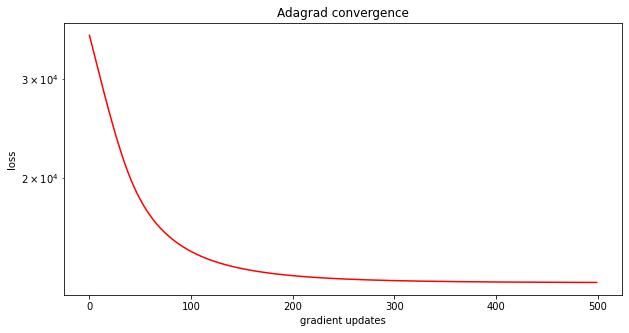

In [ ]:
_, d = train_inputs.shape
w, losses = grad_descent(lambda weight: logistic(weight, train_inputs, train_labels), np.random.rand(d), 0.0001, 500)

plt.figure(figsize=(10,5))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final train loss: %f" % losses[-1])

In [ ]:
predictions = predict(w,test_inputs)

In [ ]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average Precision: 0.014498130966629537


In [ ]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average NDCG: 0.20629537502588136


**XGBOOST with LambdaMART**

In [ ]:
import xgboost as xgb

In [ ]:
def collect_group_ids_1(sampled_qids):

  number_list = []
  helper_dict = {}

  for i in range(len(sampled_qids)):
    if(helper_dict.get(sampled_qids[i]) == None):
      helper_dict[sampled_qids[i]] = 1
    else:
      v = helper_dict.get(sampled_qids[i]) + 1
      helper_dict[sampled_qids[i]] = v

  for key in helper_dict:
    number_list.append(helper_dict.get(key))
      
  return number_list

In [ ]:
train_groupd_ids = collect_group_ids_1(sampled_qids)

In [ ]:
def collect_group_ids_2(test_relevant_passages_dict):
  number_list = []

  for key in test_relevant_passages_dict:
    passages = test_relevant_passages_dict.get(key)
    number_list.append(len(passages[0]) + len(passages[1]))

  return number_list

In [ ]:
test_group_ids = collect_group_ids_2(test_relevant_passages_dict)

In [ ]:
model = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=4, 
    n_estimators=500, 
    subsample=0.5 
    )

In [ ]:
model = model.fit(train_inputs, sampled_labels, group=train_groupd_ids, verbose=False)

In [ ]:
def get_XGBoost_predictions(model,test_relevant_passages_dict,test_inputs):

  result = []

  index = 1
  for key in test_relevant_passages_dict:
    l = test_relevant_passages_dict.get(key)
    group_input = []
    indexes = []
    for (_,i) in l[0] + l[1]:
      indexes.append(i)
      group_input.append(test_inputs[i])
    group_input = np.array(group_input)
    #print(group_input.shape)
    preds = model.predict(group_input)
    for i in range(len(indexes)):
      result.append((indexes[i],preds[i]))

  ## reorder the predictions
  result = sorted(result, key=lambda tup: tup[0], reverse = False)

  final_result = []
  for (_,p) in result:
    final_result.append(p)

  return final_result

In [ ]:
predictions = get_XGBoost_predictions(model,test_relevant_passages_dict,test_inputs)

In [ ]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average Precision: 0.012738036138242988


In [ ]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

Average NDCG: 0.17737927212459903


**Neural Network**

In [2]:
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [3]:
train_passages = joblib.load('drive/MyDrive/Vectors/train_inputs_passages')
train_queries = joblib.load('drive/MyDrive/Vectors/train_inputs_queries')
test_passages = joblib.load('drive/MyDrive/Vectors/test_inputs_passages')
test_queries = joblib.load('drive/MyDrive/Vectors/test_inputs_queries')

train_labels = np.array(joblib.load('drive/MyDrive/Vectors/train_labels'))
test_labels = joblib.load('drive/MyDrive/Vectors/test_labels')

look_up_table = joblib.load('drive/MyDrive/Vectors/look_up_table')

train_passages_lengths = joblib.load('drive/MyDrive/Vectors/train_passages_lengths')
train_queries_lengths = joblib.load('drive/MyDrive/Vectors/train_queries_lengths')
test_passages_lengths = joblib.load('drive/MyDrive/Vectors/test_passages_lengths')
test_queries_lengths = joblib.load('drive/MyDrive/Vectors/test_queries_lengths')

In [4]:
train_labels[train_labels == -1] = 0
test_labels[test_labels == -1] = 0

In [5]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device = 'cpu'

In [39]:
train_passages_data = torch.from_numpy(train_passages).int().to(device)
train_queries_data = torch.from_numpy(train_queries).int().to(device)

train_passages_lengths = torch.from_numpy(train_passages_lengths)
train_passages_lengths = torch.as_tensor(train_passages_lengths.cpu(), dtype=torch.int64)

train_queries_lengths = torch.from_numpy(train_queries_lengths)
train_queries_lengths = torch.as_tensor(train_queries_lengths.cpu(), dtype=torch.int64)

train_labels = torch.from_numpy(train_labels).to(device)

look_up_table = torch.from_numpy(look_up_table).float().to(device)

In [6]:
test_passages_data = torch.from_numpy(test_passages).int().to(device)
test_queries_data = torch.from_numpy(test_queries).int().to(device)

test_passages_lengths = torch.from_numpy(test_passages_lengths)
test_passages_lengths = torch.as_tensor(test_passages_lengths.cpu(), dtype=torch.int64)

test_queries_lengths = torch.from_numpy(test_queries_lengths)
test_queries_lengths = torch.as_tensor(test_queries_lengths.cpu(), dtype=torch.int64)

test_labels = torch.from_numpy(test_labels).to(device)

look_up_table = torch.from_numpy(look_up_table).float().to(device)

In [40]:
batch_size= 128
train_set = torch.utils.data.TensorDataset(train_passages_data, train_passages_lengths, train_queries_data, train_queries_lengths, train_labels)
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [7]:
batch_size = 128
test_set = torch.utils.data.TensorDataset(test_passages_data, test_passages_lengths, test_queries_data, test_queries_lengths, test_labels)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_passages_data.max())
print(train_passages_data.min())
print(train_passages_lengths.max())
print(train_passages_lengths.min())

tensor(32849, device='cuda:0', dtype=torch.int32)
tensor(0, device='cuda:0', dtype=torch.int32)
tensor(101)
tensor(2)


In [ ]:
print(train_queries_data.max())
print(train_queries_data.min())
print(train_queries_lengths.max())
print(train_queries_lengths.min())

tensor(32869, device='cuda:0', dtype=torch.int32)
tensor(0, device='cuda:0', dtype=torch.int32)
tensor(15)
tensor(1)


In [8]:
## define a dictionary with the parameters of the Neural Network
params_dictionary = {}
params_dictionary['embedding_size'] = look_up_table.shape[1]
params_dictionary['vocabulary_size'] = look_up_table.shape[0]
params_dictionary['hidden_dim'] = 256
params_dictionary['linear_dims'] = [128,64,32]
params_dictionary['bidirectional'] = True
params_dictionary['label_size'] = 2
params_dictionary['rnn_type'] = 'LSTM'
params_dictionary['dropout'] = 0.0
params_dictionary['rnn_layers_num'] = 1
params_dictionary['attention_layer'] = True
params_dictionary['concat_layer'] = [64,32]

In [9]:
class Attention(nn.Module):
    def __init__(self, device,hidden_size):
        super(Attention, self).__init__()
        self.device = device
        self.hidden_size = hidden_size

        self.concat_linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, hidden_size)

        ## add this model the same same device with the RNN
        self.to(device)

    def forward(self, rnn_outputs, final_hidden_state):
      attn_weights = self.attn(rnn_outputs) # (batch_size, seq_len, hidden_dim)
      attn_weights = torch.bmm(attn_weights, final_hidden_state.unsqueeze(2))
      attn_weights = F.softmax(attn_weights.squeeze(2), dim=1)
      context = torch.bmm(rnn_outputs.transpose(1, 2), attn_weights.unsqueeze(2)).squeeze(2)
      attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state), dim=1)))
      return attn_hidden, attn_weights

In [10]:
class RnnClassifier(nn.Module):
    def __init__(self, device, params_dictionary,look_up_table):
        super(RnnClassifier, self).__init__()
        self.params = params_dictionary
        self.device = device

        # Calculate number of directions
        self.num_directions = 2 if self.params.get('bidirectional') == True else 1

        # define an attention model
        # Choose attention model
        self.attention = Attention(self.device,self.params.get('hidden_dim')* self.num_directions)

        # Embedding layer (vocabulary_size X embedding_dimension)
        self.word_embeddings = nn.Embedding.from_pretrained(look_up_table)

        ## here store in a list all the dimensions of the layers rnn_output --> linear layers --> labels layer
        self.linear_dims = [self.params.get('hidden_dim') * self.num_directions] + self.params.get('linear_dims')

        # Work with LSTM cell for now
        self.rnn = nn.LSTM

        ## define the RNN layer
        self.rnn = self.rnn(self.params.get('embedding_size'),
                            self.params.get('hidden_dim'),
                            num_layers=self.params.get('rnn_layers_num'),
                            bidirectional=self.params.get('bidirectional'),
                            dropout=float(self.params.get('dropout')),
                            batch_first=True)
        
        ## the hidden state of the RNN empty for now
        self.hidden = None
        
        # Define set of fully connected layers (Linear Layer + Activation Layer)
        ## this set of layers takes the output of the RNN or the Attention layer and applies a feedforward NN on it
        ## consecutive linear + Relu layers are applied (the final layer does not have a relu activation!)
        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            self.linears.append(nn.ReLU())

        self.to(self.device)

    def init_weights(self, layer):
      if type(layer) == nn.Linear:
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)

    def init_hidden(self, batch_size):
      return (torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device),
              torch.zeros(self.params.get('rnn_layers_num') * self.num_directions, batch_size, self.params.get('hidden_dim')).to(self.device))
      

    def forward(self, inputs, X_lengths):
        batch_size, seq_len = inputs.shape

        ## Push through embedding layer
        embedded_inputs = self.word_embeddings(inputs)

        ## initialise the hidden state of the RNN
        self.hidden = self.init_hidden(batch_size)

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        padded_X = torch.nn.utils.rnn.pack_padded_sequence(embedded_inputs, X_lengths, batch_first=True, enforce_sorted = False)

        ## pass the data through the recurrent layer
        rnn_output, self.hidden = self.rnn(padded_X, self.hidden)

        # undo the packing operation
        rnn_output_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(rnn_output, batch_first=True)

        ## Collect last hidden state
        final_state = self.hidden[0].view(self.params.get('rnn_layers_num'), self.num_directions, batch_size, self.params.get('hidden_dim'))[-1]

        # Handle directions if more than one
        final_hidden_state = None
        ## in case we have only one direction
        if self.num_directions == 1:
            final_hidden_state = final_state.squeeze(0)
        ## in case we have 2 directions concatenate these two states
        elif self.num_directions == 2:
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)  # Concatenate both states

        ## Attention Layer
        if(self.params.get('attention_layer') == False):
          X = final_hidden_state
        else:
          rnn_output = rnn_output_unpacked.permute(1, 0, 2)
          X, attention_weights = self.attention(rnn_output_unpacked, final_hidden_state)

        # Push through linear layers
        for l in self.linears:
            X = l(X)

        #print(X.shape)

        #log_probs = F.log_softmax(X, dim=1)

        #print(log_probs.shape)

        return X

In [11]:
class RankingModel(nn.Module):

  def __init__(self, device, params_dictionary,look_up_table):
        super(RankingModel, self).__init__()
        self.params = params_dictionary
        self.device = device

        self.passage_network = RnnClassifier(device,params_dictionary,look_up_table)
        self.query_network = RnnClassifier(device,params_dictionary,look_up_table)

        self.linear_dims = [self.params.get('linear_dims')[-1]*2] + self.params.get('concat_layer')
        self.linear_dims.append(self.params.get('label_size'))

        self.linears = nn.ModuleList()
        for i in range(0, len(self.linear_dims)-1):
            if self.params.get('dropout') > 0.0:
                self.linears.append(nn.Dropout(p=self.params.get('dropout')))
            linear_layer = nn.Linear(self.linear_dims[i], self.linear_dims[i+1])
            self.init_weights(linear_layer)
            self.linears.append(linear_layer)
            if i == len(self.linear_dims) - 1:
                break
            self.linears.append(nn.ReLU())

        self.to(self.device)

  def init_weights(self, layer):
    if type(layer) == nn.Linear:
      torch.nn.init.xavier_uniform_(layer.weight)
      layer.bias.data.fill_(0.01)

  def forward(self, passage_inputs, passage_lengths, query_inputs, query_lengths):

    passage_output = self.passage_network.forward(passage_inputs,passage_lengths)
    query_output = self.query_network.forward(query_inputs,query_lengths)
    concatenated_output = torch.cat((passage_output,query_output),dim=1)

    X = concatenated_output

    for l in self.linears:
      X = l(X)

    return X

In [45]:
model = RankingModel(device, params_dictionary,look_up_table)

In [46]:
loss_function = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.0001)

loss = []

epochs = 200

for i in range(epochs):
  loss_batches = []
  for batch_index,training_batch in enumerate (train_set_loader,0):

      passage_input, passage_lengths, query_input, query_lengths, labels = training_batch
      labels,p_inputs,q_inputs,p_lengths,q_lengths = Variable(labels), Variable(passage_input), Variable(query_input), Variable(passage_lengths), Variable(query_lengths)
      optimizer.zero_grad()
      y_pred = model.forward(p_inputs,p_lengths,q_inputs,q_lengths)
      single_loss = loss_function(y_pred,labels).to(device)
      single_loss.backward()
      optimizer.step()
      loss_batches.append(single_loss.item())
  loss.append(np.mean(np.array(loss_batches)))
  print("epoch  " + str(i+1) + " " + str(loss[-1]))
  clear_output(wait=True)

epoch  200 0.0005510665312713717


In [47]:
torch.save(model.state_dict(), 'drive/MyDrive/Models/RankingNN')

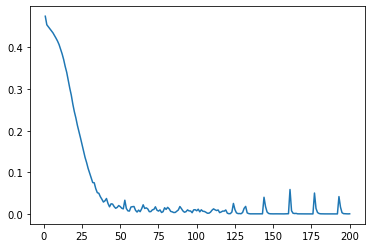

In [48]:
iters = [i+1 for i in range(epochs)]
plt.plot(iters,loss)

**Loading the Neural Net in order to make predictions**

In [12]:
model = RankingModel(device, params_dictionary,look_up_table)
model.load_state_dict(torch.load('drive/MyDrive/Models/RankingNN'))
model.eval()

RankingModel(
  (passage_network): RnnClassifier(
    (attention): Attention(
      (concat_linear): Linear(in_features=1024, out_features=512, bias=True)
      (attn): Linear(in_features=512, out_features=512, bias=True)
    )
    (word_embeddings): Embedding(53806, 300)
    (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
    (linears): ModuleList(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
    )
  )
  (query_network): RnnClassifier(
    (attention): Attention(
      (concat_linear): Linear(in_features=1024, out_features=512, bias=True)
      (attn): Linear(in_features=512, out_features=512, bias=True)
    )
    (word_embeddings): Embedding(53806, 300)
    (rnn): LSTM(300, 256, batch_first=True, bidirectional=True)
    (linears): ModuleList(
      (0): Linear(in_features=512, 

In [ ]:
predictions = []
for batch_index,training_batch in enumerate (test_set_loader,0):
  passage_input, passage_lengths, query_input, query_lengths, labels = training_batch
  labels,p_inputs,q_inputs,p_lengths,q_lengths = Variable(labels), Variable(passage_input), Variable(query_input), Variable(passage_lengths), Variable(query_lengths)
  test_predictions = model.forward(p_inputs,p_lengths,q_inputs,q_lengths)
  for t in test_predictions:
    if(t[0] > t[1]):
      predictions.append(-t[0])
    else:
      predictions.append(t[1])

In [ ]:
Average_Precision(predictions,test_labels,test_query_dict,test_relevant_passages_dict)

In [ ]:
Average_NDCG(predictions,test_labels,test_query_dict,test_relevant_passages_dict)